In [2]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM

Data Ingestion

In [3]:
data = pd.read_excel('5years_database.xlsx', sheet_name='Data')
data.head(5)

,Date,Close
0,04/06/2023,4105.02
1,04/05/2023,4090.38
2,04/04/2023,4100.60
3,04/03/2023,4124.51
4,03/31/2023,4109.31


In [5]:
data['Close'] = pd.to_numeric(data['Close'])

In [6]:
def prepare_data_for_model_input(data, ma):
    
    data['sp500_close_ma'] = data['Close'].rolling(ma).mean()
    data['sp500_log_return'] = np.log(data['Close']/data['Close'].shift(1)).dropna()

    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y') 
    data.set_index('Date', inplace=True)

    data_array = np.array(data[['sp500_log_return']])
    
    return data, data_array

In [21]:
data, data_array = prepare_data_for_model_input(data, 7)
data

,index,Close,sp500_close_ma,sp500_log_return
Date,,,,
2023-03-29,6,4027.81,4086.922857,-0.005699
2023-03-28,7,3971.27,4067.815714,-0.014137
2023-03-27,8,3977.53,4051.694286,0.001575
2023-03-24,9,3970.99,4033.178571,-0.001646
2023-03-23,10,3948.72,4008.065714,-0.005624
...,...,...,...,...
2018-04-16,1253,2677.84,2680.141429,-0.010605
2018-04-13,1254,2656.30,2683.247143,-0.008076
2018-04-12,1255,2663.99,2682.347143,0.002891


In [22]:
class RegimeDetection:

 def get_regimes_hmm(self, input_data, params):
      hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
      return hmm_model
 def get_regimes_clustering(self, params):
       clustering = self.initialise_model(AgglomerativeClustering(), params)
       return clustering
 def get_regimes_gmm(self, input_data, params):
       gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
       return gmm
 def initialise_model(self, model, params):
      for parameter, value in params.items():
         setattr(model, parameter, value)
      return model


In [38]:
def plot_hidden_states(hidden_states, data_df):
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    data_df(df) - dataframe of market data

    Output:
    Graph showing hidden states and market data
    '''

    colors = ['green', 'blue']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i, ":", len(data_df.index[mask]))

        x_axis = [dt.strftime('%Y-%m-%d') for dt in data_df.index[mask].tolist()]

        fig.add_trace(go.Scatter(x=x_axis, y=data_df['Close'][mask],
                     mode='markers', name='Hidden State ' + str(i), marker=dict(size=4, color=colors[i])))
        #fig.add_trace(go.Scatter(x=x_axis, y=data_df['Close'][mask],
         #            mode='markers', name='Hidden State ' + str(i), marker=dict(size=4, color=colors[i%2])))
    fig.update_layout(height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left", x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()


In [24]:
rd = RegimeDetection()

In [25]:
params = {'n_components': 2, 'covariance_type': "full", 'random_state': 100}
hmm_model = rd.get_regimes_hmm(data_array, params)
hmm_states = hmm_model.predict(data_array)
plot_hidden_states(np.array(hmm_states), data[['Close']])


Number of observations for State  0 : 104
Number of observations for State  1 : 1148


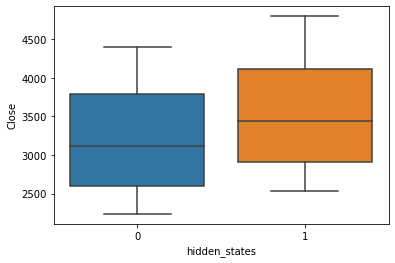

In [33]:
plot_boxplot(hmm_states, data)